In [1]:
import pandas as pd
import numpy as np

# 데이터 로드
orders = pd.read_csv('data/orders.csv')
order_products = pd.read_csv('data/order_products__prior.csv')
products = pd.read_csv('data/products.csv')
aisles = pd.read_csv('data/aisles.csv')
departments = pd.read_csv('data/departments.csv')

In [71]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
160,1737705,17,prior,1,2,13,8.0
161,1681401,17,prior,2,5,10,3.0
162,2680214,17,prior,3,3,10,5.0
163,3197376,17,prior,4,1,14,5.0
164,3237467,17,prior,5,6,17,5.0


In [72]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered
28434123,2998689,1,3,0
19923843,2101389,1,4,1
20893243,2203994,1,11,1
8962795,946234,1,8,0
189214,19939,1,2,0


In [2]:
# 고객별 주문 횟수 계산
user_order_counts = orders.groupby('user_id').size()

# 상위 20% 고객 선택
top_users = user_order_counts[user_order_counts >= user_order_counts.quantile(0.8)].index

# 필터링 적용
orders = orders[orders['user_id'].isin(top_users)]

# days_since_prior_order(직전 주문 이후 현재 주문에 이르기까지 걸린 기간)의 결측치를 user_id의 평균값으로 대체
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(orders.groupby('user_id')\
                                                                           ['days_since_prior_order'].transform('mean'))

In [3]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
160,1737705,17,prior,1,2,13,8.0
161,1681401,17,prior,2,5,10,3.0
162,2680214,17,prior,3,3,10,5.0
163,3197376,17,prior,4,1,14,5.0
164,3237467,17,prior,5,6,17,5.0


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1828618 entries, 160 to 3421068
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 111.6+ MB


In [64]:
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(orders.groupby('user_id')['days_since_prior_order'].transform('mean'))

In [65]:
orders.groupby('user_id')['days_since_prior_order'].mean()

user_id
17         8.000000
21        10.365546
27         4.432099
28        11.541667
36         9.379332
            ...    
206197    13.086957
206200     8.826087
206201    10.718750
206206     3.716418
206208     7.367347
Name: days_since_prior_order, Length: 42499, dtype: float64

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
160,1737705,17,prior,1,2,13,8.0
161,1681401,17,prior,2,5,10,3.0
162,2680214,17,prior,3,3,10,5.0
163,3197376,17,prior,4,1,14,5.0
164,3237467,17,prior,5,6,17,5.0
165,2616505,17,prior,6,4,17,5.0
166,2648319,17,prior,7,1,13,4.0
167,2430354,17,prior,8,0,15,6.0
168,2373492,17,prior,9,3,13,3.0
169,900554,17,prior,10,0,15,4.0


In [9]:
# 상품별 주문 횟수 계산
product_order_counts = order_products.groupby('product_id').size()

# 상위 20% 상품 선택
top_products = product_order_counts[product_order_counts >= product_order_counts.quantile(0.8)].index

# 필터링 적용
order_products = order_products[order_products['product_id'].isin(top_products)]

In [5]:
order_products

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [7]:
# 층화추출로 20퍼센트 추출
order_products = order_products.groupby('product_id', group_keys=False).apply(lambda x:x.sample(frac=0.2))

order_products

,order_id,product_id,add_to_cart_order,reordered
9381129,990267,1,3,0
23899050,2520480,1,4,1
1636172,172436,1,8,0
14116771,1489840,1,1,0
3360131,354895,1,3,1
...,...,...,...,...
130726,13797,49688,2,1
8040939,848810,49688,22,0
23268450,2454083,49688,8,0
17986256,1897157,49688,14,0


In [8]:
del order_details

In [9]:
# 주문 정보와 상품 주문 정보 병합
order_details = pd.merge(order_products, orders, 
                         on='order_id', how='inner')

# 상품 정보 병합
order_details = pd.merge(order_details, products, 
                         on='product_id', how='inner')

# 상품의 카테고리 정보 병합
order_details = pd.merge(order_details, aisles, on='aisle_id', how='left')
order_details = pd.merge(order_details, departments, on='department_id', how='left')

print(order_details.shape)  # 데이터 크기 확인

(3634568, 15)


In [10]:
order_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3634568 entries, 0 to 3634567
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   product_id              int64  
 2   add_to_cart_order       int64  
 3   reordered               int64  
 4   user_id                 int64  
 5   eval_set                object 
 6   order_number            int64  
 7   order_dow               int64  
 8   order_hour_of_day       int64  
 9   days_since_prior_order  float64
 10  product_name            object 
 11  aisle_id                int64  
 12  department_id           int64  
 13  aisle                   object 
 14  department              object 
dtypes: float64(1), int64(10), object(4)
memory usage: 443.7+ MB


In [11]:
order_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2520480,1,4,1,115353,prior,17,1,17,7.000000,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,1489840,1,1,0,64588,prior,1,3,14,6.653846,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
2,354895,1,3,1,91160,prior,56,1,18,5.000000,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
3,1564492,1,5,1,141947,prior,12,2,13,7.000000,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
4,2390631,1,4,1,45784,prior,10,1,8,8.000000,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks


In [51]:
order_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3633680 entries, 0 to 3633679
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   product_id              int64  
 2   add_to_cart_order       int64  
 3   reordered               int64  
 4   user_id                 int64  
 5   eval_set                object 
 6   order_number            int64  
 7   order_dow               int64  
 8   order_hour_of_day       int64  
 9   days_since_prior_order  float64
 10  product_name            object 
 11  aisle_id                int64  
 12  department_id           int64  
 13  aisle                   object 
 14  department              object 
dtypes: float64(1), int64(10), object(4)
memory usage: 443.6+ MB


In [12]:
# 데이터 타입 최적화
order_details['order_id'] = order_details['order_id'].astype('int32')
order_details['product_id'] = order_details['product_id'].astype('int32')
order_details['user_id'] = order_details['user_id'].astype('int32')
order_details['aisle_id'] = order_details['aisle_id'].astype('int16')
order_details['department_id'] = order_details['department_id'].astype('int16')
order_details['reordered'] = order_details['reordered'].astype('int8')

print(order_details.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3634568 entries, 0 to 3634567
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int32  
 1   product_id              int32  
 2   add_to_cart_order       int64  
 3   reordered               int8   
 4   user_id                 int32  
 5   eval_set                object 
 6   order_number            int64  
 7   order_dow               int64  
 8   order_hour_of_day       int64  
 9   days_since_prior_order  float64
 10  product_name            object 
 11  aisle_id                int16  
 12  department_id           int16  
 13  aisle                   object 
 14  department              object 
dtypes: float64(1), int16(2), int32(3), int64(4), int8(1), object(4)
memory usage: 336.2+ MB
None


In [53]:
# 고객별 구매 패턴
user_features = order_details.groupby('user_id').agg(
    user_total_orders=('order_number', 'max'),
    user_total_products=('product_id', 'count'),
    user_reorder_rate=('reordered', 'mean'),
    user_avg_cart_size=('add_to_cart_order', 'mean'),
).reset_index()

In [54]:
user_features

,user_id,user_total_orders,user_total_products,user_reorder_rate,user_avg_cart_size
0,17,40,56,0.714286,4.857143
1,21,33,41,0.487805,4.658537
2,27,81,145,0.731034,8.248276
3,28,24,34,0.441176,6.617647
4,36,37,34,0.500000,3.588235
...,...,...,...,...,...
42493,206197,23,35,0.714286,4.400000
42494,206200,23,55,0.563636,9.145455
42495,206201,32,88,0.477273,8.590909
42496,206206,67,66,0.500000,4.090909


In [55]:
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42498 entries, 0 to 42497
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              42498 non-null  int64  
 1   user_total_orders    42498 non-null  int64  
 2   user_total_products  42498 non-null  int64  
 3   user_reorder_rate    42498 non-null  float64
 4   user_avg_cart_size   42498 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 1.6 MB


In [56]:
user_features.head()

,user_id,user_total_orders,user_total_products,user_reorder_rate,user_avg_cart_size
0,17,40,56,0.714286,4.857143
1,21,33,41,0.487805,4.658537
2,27,81,145,0.731034,8.248276
3,28,24,34,0.441176,6.617647
4,36,37,34,0.500000,3.588235


In [57]:
# 상품별 구매 패턴
product_features = order_details.groupby('product_id').agg(
    product_total_orders=('order_id', 'count'),
    product_reorder_rate=('reordered', 'mean'),
    product_avg_add_to_cart=('add_to_cart_order', 'mean')
).reset_index()
product_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42954 entries, 0 to 42953
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_id               42954 non-null  int64  
 1   product_total_orders     42954 non-null  int64  
 2   product_reorder_rate     42954 non-null  float64
 3   product_avg_add_to_cart  42954 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 1.3 MB


In [58]:
product_features.head()

,product_id,product_total_orders,product_reorder_rate,product_avg_add_to_cart
0,1,209,0.712919,6.129187
1,2,10,0.100000,5.500000
2,3,43,0.930233,5.976744
3,4,25,0.560000,9.240000
4,5,1,1.000000,7.000000


In [59]:
# 고객-상품 조합 정보
user_product_features = order_details.groupby(['user_id', 'product_id']).agg(
    user_product_orders=('order_id', 'count'),
    user_product_reorder_rate=('reordered', 'mean'),
    user_product_reorder_days=('days_since_prior_order','mean')
).reset_index()
user_product_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2124616 entries, 0 to 2124615
Data columns (total 5 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   user_id                    int64  
 1   product_id                 int64  
 2   user_product_orders        int64  
 3   user_product_reorder_rate  float64
 4   user_product_reorder_days  float64
dtypes: float64(2), int64(3)
memory usage: 81.0 MB


In [84]:
user_product_features.head()

,user_id,product_id,user_product_orders,user_product_reorder_rate,user_product_reorder_days
0,17,1774,2,1.0,6.000000
1,17,2927,1,0.0,5.000000
2,17,6212,2,1.0,4.500000
3,17,7026,1,0.0,6.000000
4,17,7350,7,1.0,17.142857


In [60]:
# 고객-상품 조합에 고객 정보 병합
final_data = pd.merge(user_product_features, user_features, on='user_id', how='left')

# 고객-상품 조합에 상품 정보 병합
final_data = pd.merge(final_data, product_features, on='product_id', how='left')

print(final_data.shape)  # 데이터 크기 확인

(2124616, 12)


In [61]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2124616 entries, 0 to 2124615
Data columns (total 12 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   user_id                    int64  
 1   product_id                 int64  
 2   user_product_orders        int64  
 3   user_product_reorder_rate  float64
 4   user_product_reorder_days  float64
 5   user_total_orders          int64  
 6   user_total_products        int64  
 7   user_reorder_rate          float64
 8   user_avg_cart_size         float64
 9   product_total_orders       int64  
 10  product_reorder_rate       float64
 11  product_avg_add_to_cart    float64
dtypes: float64(6), int64(6)
memory usage: 210.7 MB


In [16]:
final_data.head()

,user_id,product_id,user_product_orders,user_product_reorder_rate,user_total_orders,user_total_products,user_reorder_rate,user_avg_cart_size,product_total_orders,product_reorder_rate,product_avg_add_to_cart
0,17,1774,2,1.0,40,67,0.671642,4.492537,126,0.587302,7.857143
1,17,2927,1,0.0,40,67,0.671642,4.492537,20,0.400000,8.500000
2,17,6212,2,1.0,40,67,0.671642,4.492537,29,0.689655,8.724138
3,17,7026,1,0.0,40,67,0.671642,4.492537,241,0.775934,7.024896
4,17,7350,7,1.0,40,67,0.671642,4.492537,424,0.820755,6.849057


In [87]:
final_data = final_data.drop(['user_total_orders', 'product_total_orders', 'user_product_orders'], axis=1)

In [88]:
final_data.head()

,user_id,product_id,user_product_reorder_rate,user_product_reorder_days,user_total_products,user_reorder_rate,user_avg_cart_size,product_reorder_rate,product_avg_add_to_cart
0,17,1774,1.0,6.000000,67,0.671642,4.492537,0.587302,7.857143
1,17,2927,0.0,5.000000,67,0.671642,4.492537,0.400000,8.500000
2,17,6212,1.0,4.500000,67,0.671642,4.492537,0.689655,8.724138
3,17,7026,0.0,6.000000,67,0.671642,4.492537,0.775934,7.024896
4,17,7350,1.0,17.142857,67,0.671642,4.492537,0.820755,6.849057


In [23]:
final_data.head()

,user_id,product_id,user_product_reorder_rate,user_total_products,user_reorder_rate,user_avg_cart_size,product_reorder_rate,product_avg_add_to_cart,target
0,17,1774,1.0,67,0.671642,4.492537,0.587302,7.857143,1
1,17,2927,0.0,67,0.671642,4.492537,0.400000,8.500000,0
2,17,6212,1.0,67,0.671642,4.492537,0.689655,8.724138,1
3,17,7026,0.0,67,0.671642,4.492537,0.775934,7.024896,0
4,17,7350,1.0,67,0.671642,4.492537,0.820755,6.849057,1


In [89]:
# 불필요한 구매를 정의하는 기준 (재구매 확률이 0.3 이하인 경우, 재구매 기간이 15일 이상인 경우)
threshold = 0.3
reorder_days = 15

# 'target' 컬럼 생성: 재구매 확률이 0.6 이하 -> 0 (불필요), 0.3 이상 -> 1 (필요)
final_data['target'] = final_data['user_product_reorder_rate'].apply(lambda x: 1 if x >= threshold else 0)
final_data['target'] = final_data['user_product_reorder_days'].apply(lambda x: 1 if x >= reorder_days else 0)

# 종속변수 확인
final_data[['user_id', 'product_id', 'user_product_reorder_rate', 'target']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2123873 entries, 0 to 2123872
Data columns (total 4 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   user_id                    int64  
 1   product_id                 int64  
 2   user_product_reorder_rate  float64
 3   target                     int64  
dtypes: float64(1), int64(3)
memory usage: 81.0 MB


In [90]:
final_data[['user_id', 'product_id', 'user_product_reorder_rate', 'target']].head()

,user_id,product_id,user_product_reorder_rate,target
0,17,1774,1.0,0
1,17,2927,0.0,0
2,17,6212,1.0,0
3,17,7026,0.0,0
4,17,7350,1.0,1


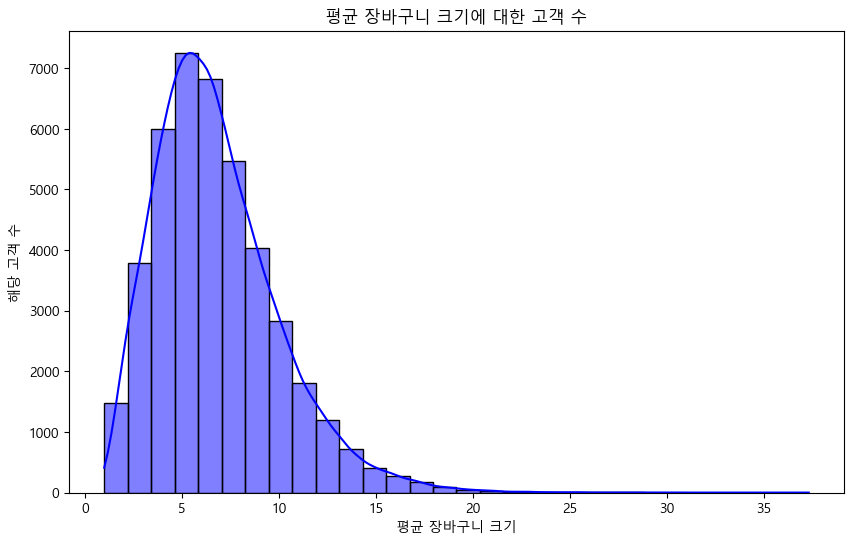

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# 고객별 평균 장바구니 크기 계산
user_avg_cart_size = order_details.groupby('user_id')['add_to_cart_order'].mean()

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
sns.histplot(user_avg_cart_size, bins=30, kde=True, color='blue')
plt.title('평균 장바구니 크기에 대한 고객 수')
plt.xlabel('평균 장바구니 크기')
plt.ylabel('해당 고객 수')
plt.show()

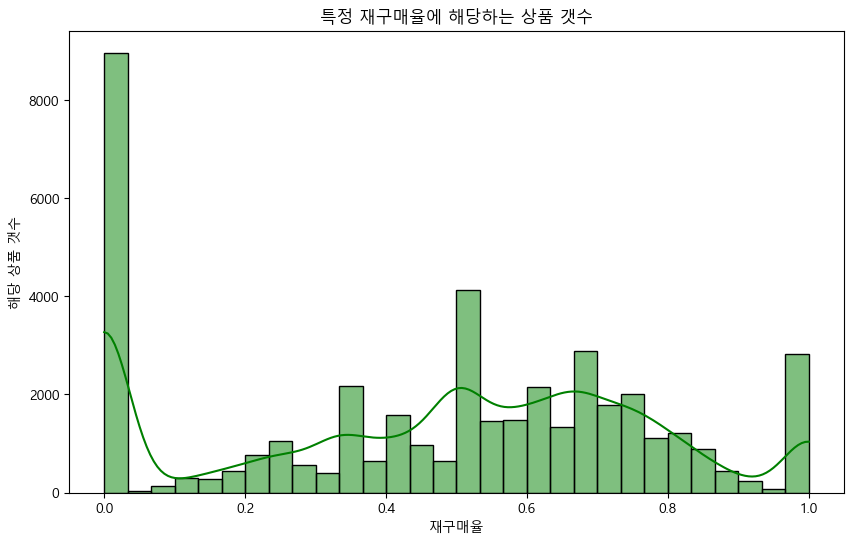

In [63]:
# 상품별 재구매율 계산
product_reorder_rate = order_details.groupby('product_id')['reordered'].mean()

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
sns.histplot(product_reorder_rate, bins=30, kde=True, color='green')
plt.title('특정 재구매율에 해당하는 상품 갯수')
plt.xlabel('재구매율')
plt.ylabel('해당 상품 갯수')
plt.show()

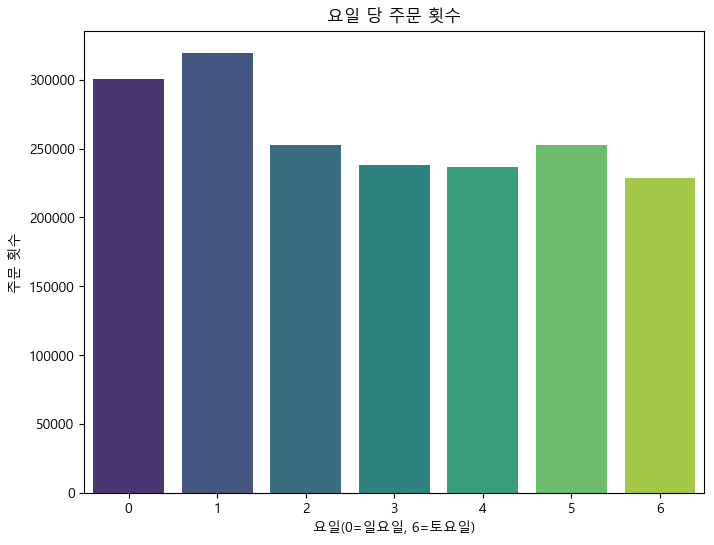

In [64]:
# 요일별 주문량 계산
order_dow_counts = orders['order_dow'].value_counts().sort_index()

# 막대그래프 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x=order_dow_counts.index, y=order_dow_counts.values, palette='viridis')
plt.title('요일 당 주문 횟수')
plt.xlabel('요일(0=일요일, 6=토요일)')
plt.ylabel('주문 횟수')
plt.show()

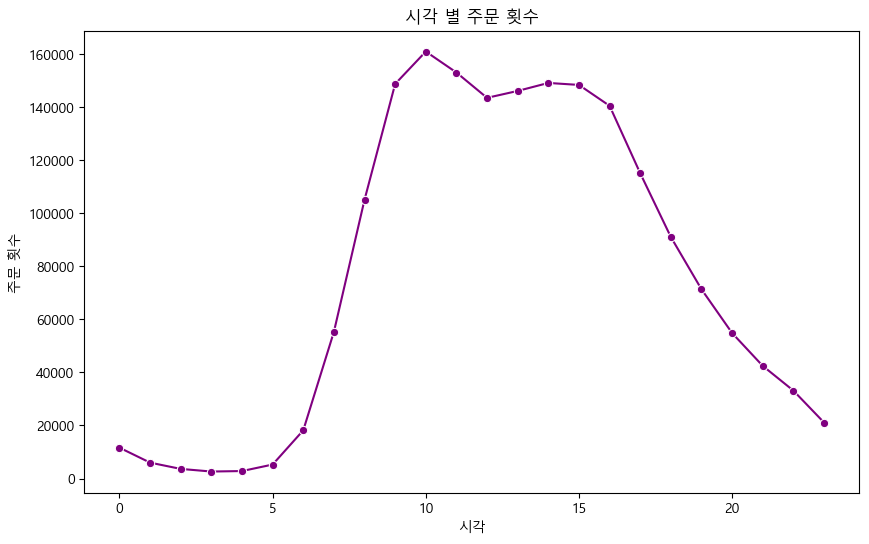

In [65]:
# 시간대별 주문량 계산
order_hour_counts = orders['order_hour_of_day'].value_counts().sort_index()

# 선 그래프 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(x=order_hour_counts.index, y=order_hour_counts.values, marker='o', color='purple')
plt.title('시각 별 주문 횟수')
plt.xlabel('시각')
plt.ylabel('주문 횟수')
plt.show()

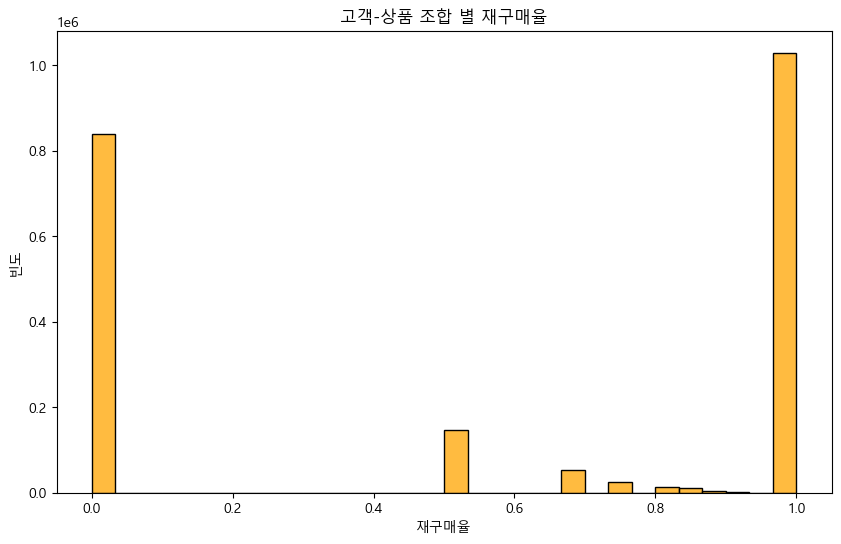

In [66]:
# 고객-상품 조합별 재구매율 계산
user_product_reorder_rate = user_product_features['user_product_reorder_rate']

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
sns.histplot(user_product_reorder_rate, bins=30, color='orange')
plt.title('고객-상품 조합 별 재구매율')
plt.xlabel('재구매율')
plt.ylabel('빈도')
plt.show()

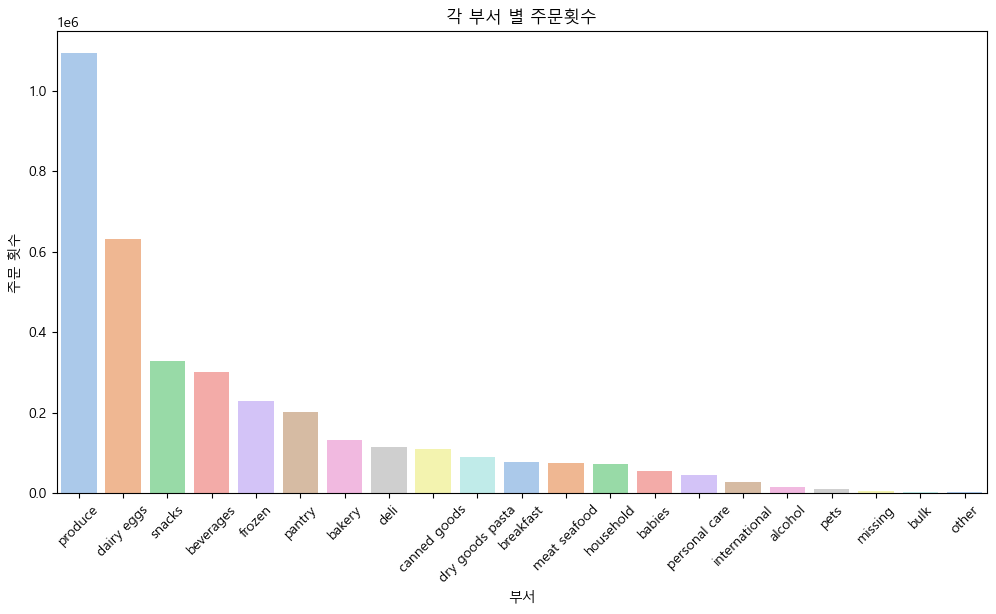

In [67]:
# 부서별 주문량 계산
department_order_counts = order_details['department'].value_counts()

# 막대그래프 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=department_order_counts.index, y=department_order_counts.values, palette='pastel')
plt.title('각 부서 별 주문횟수')
plt.xticks(rotation=45)
plt.xlabel('부서')
plt.ylabel('주문 횟수')
plt.show()

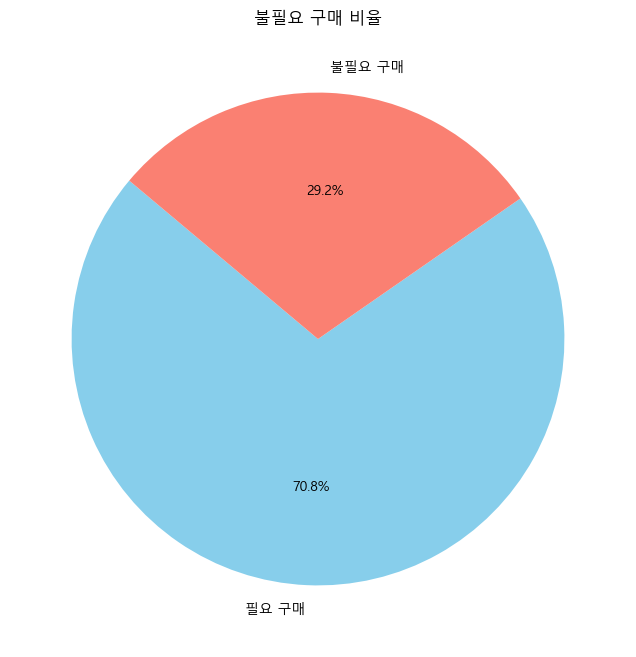

In [68]:
# 상품별 재구매율 기준으로 불필요 구매 분류
threshold = 0.3  # 재구매율이 30% 미만인 경우를 불필요 구매로 정의
product_reorder_rate = order_details.groupby('product_id')['reordered'].mean()
unnecessary_purchase_rate = (product_reorder_rate < threshold).mean()

# Pie 차트로 비율 시각화
labels = ['필요 구매', '불필요 구매']
sizes = [1 - unnecessary_purchase_rate, unnecessary_purchase_rate]
colors = ['skyblue', 'salmon']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('불필요 구매 비율')
plt.show()

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential  # 모델 생성
from tensorflow.keras.layers import Dense, Input, Dropout

In [2]:
import tensorflow as tf

tf.__version__

'2.10.0'

In [5]:
import numpy as np
np.__version__

'1.23.5'

In [92]:
# 최종 데이터 셋에서 user_id, product_id 컬럼 제거
final_data_ind = final_data.drop(['user_id', 'product_id'], axis=1)
final_data_ind.head()

,user_product_reorder_rate,user_product_reorder_days,user_total_products,user_reorder_rate,user_avg_cart_size,product_reorder_rate,product_avg_add_to_cart,target
0,1.0,6.000000,67,0.671642,4.492537,0.587302,7.857143,0
1,0.0,5.000000,67,0.671642,4.492537,0.400000,8.500000,0
2,1.0,4.500000,67,0.671642,4.492537,0.689655,8.724138,0
3,0.0,6.000000,67,0.671642,4.492537,0.775934,7.024896,0
4,1.0,17.142857,67,0.671642,4.492537,0.820755,6.849057,1


In [93]:
from sklearn.model_selection import train_test_split

# 10% 샘플링 (층화 샘플링)
sampled_data, _ = train_test_split(
    final_data_ind, 
    test_size=0.9,  # 전체 데이터의 90%를 제외
    stratify=final_data['target'],  # 종속변수 기준으로 층화
    random_state=42
)

print("샘플링 후 데이터 크기:", sampled_data.shape)

샘플링 후 데이터 크기: (212387, 8)


In [11]:
sampled_data.to_csv('data/sampled_data.csv')

In [7]:
import pandas as pd

In [12]:
sampled_data = pd.read_csv('data/sampled_data.csv')

In [13]:
sampled_data = sampled_data.iloc[:, 2:]

In [14]:
sampled_data

,user_product_reorder_rate,user_product_reorder_days,user_total_products,user_reorder_rate,user_avg_cart_size,product_reorder_rate,product_avg_add_to_cart,target
0,0.000000,3.0,35,0.542857,3.828571,0.369369,10.798799,0
1,0.000000,7.0,115,0.782609,8.495652,0.000000,12.750000,0
2,1.000000,6.5,166,0.765060,9.801205,0.638332,10.665403,0
3,0.000000,2.0,91,0.659341,10.681319,0.413043,7.630435,0
4,1.000000,3.5,116,0.706897,6.327586,0.695271,9.173380,0
...,...,...,...,...,...,...,...,...
212381,0.000000,8.0,79,0.493671,6.734177,0.733333,8.785185,0
212382,0.000000,6.0,158,0.689873,13.012658,0.597222,9.625000,0
212383,0.666667,13.0,119,0.705882,10.075630,0.708300,9.627720,0
212384,0.000000,13.0,58,0.482759,6.362069,0.750078,9.472248,0


In [15]:
sampled_data.shape

(212386, 8)

In [16]:
# 독립변수 정규화 스케일링
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(sampled_data.iloc[:, :-1])

X_scaled.shape

(212386, 7)

In [40]:
del order_products

In [28]:
print(X_scaled[:5])

[[0.         0.20871143 0.8329443  0.10554463 0.85673883 0.48087034]
 [0.7578125  0.24936479 0.82069836 0.17358574 0.67569577 0.78592506]
 [0.84201389 0.02395644 0.63700414 0.05995906 0.94077525 0.07016417]
 [0.909375   0.18656987 0.8778399  0.14695437 0.76028027 0.61129398]
 [0.         0.17313975 0.79005179 0.20706153 0.69610594 0.7981973 ]]


In [17]:
# 종속변수 분리(target)
y = sampled_data.iloc[:,-1]
y.shape

(212386,)

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# 훈련, 테스트 데이터셋 분류
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((169908, 7), (42478, 7), (169908,), (42478,))

In [25]:
X_train.shape[1]

7

In [23]:
# DNN모델 설계
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'), 
    Dropout(0.3),                                             
    Dense(32, activation='relu'),                            
    Dropout(0.3),                                             
    Dense(16, activation='relu'),                             
    Dense(1, activation='sigmoid')                            
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,137
Trainable params: 3,137
Non-trainabl

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=10, 
                    batch_size=128, 
                    verbose=1)

Epoch 1/10
1328/1328 [==============================] - 3s 2ms/step - loss: 0.0698 - accuracy: 0.9746 - val_loss: 0.0146 - val_accuracy: 0.9942
Epoch 2/10
1328/1328 [==============================] - 3s 2ms/step - loss: 0.0165 - accuracy: 0.9934 - val_loss: 0.0064 - val_accuracy: 0.9982
Epoch 3/10
1328/1328 [==============================] - 3s 2ms/step - loss: 0.0111 - accuracy: 0.9958 - val_loss: 0.0043 - val_accuracy: 0.9994
Epoch 4/10
1328/1328 [==============================] - 3s 2ms/step - loss: 0.0082 - accuracy: 0.9969 - val_loss: 0.0060 - val_accuracy: 0.9973
Epoch 5/10
1328/1328 [==============================] - 3s 2ms/step - loss: 0.0069 - accuracy: 0.9975 - val_loss: 0.0053 - val_accuracy: 0.9979
Epoch 6/10
1328/1328 [==============================] - 3s 2ms/step - loss: 0.0062 - accuracy: 0.9978 - val_loss: 0.0064 - val_accuracy: 0.9963
Epoch 7/10
1328/1328 [==============================] - 3s 2ms/step - loss: 0.0064 - accuracy: 0.9975 - val_loss: 0.0033 - val_accuracy:

In [27]:
model.save('model/model.h5')

In [101]:
order_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2583277,1,18,1,128033,prior,26,1,9,7.0,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2294387,1,10,0,34179,prior,37,2,11,7.0,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
2,1220882,1,2,1,141947,prior,13,2,13,14.0,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
3,1761751,1,4,0,139616,prior,8,2,8,3.0,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
4,1580708,1,1,0,173443,prior,42,2,0,16.0,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks


In [102]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
160,1737705,17,prior,1,2,13,8.0
161,1681401,17,prior,2,5,10,3.0
162,2680214,17,prior,3,3,10,5.0
163,3197376,17,prior,4,1,14,5.0
164,3237467,17,prior,5,6,17,5.0


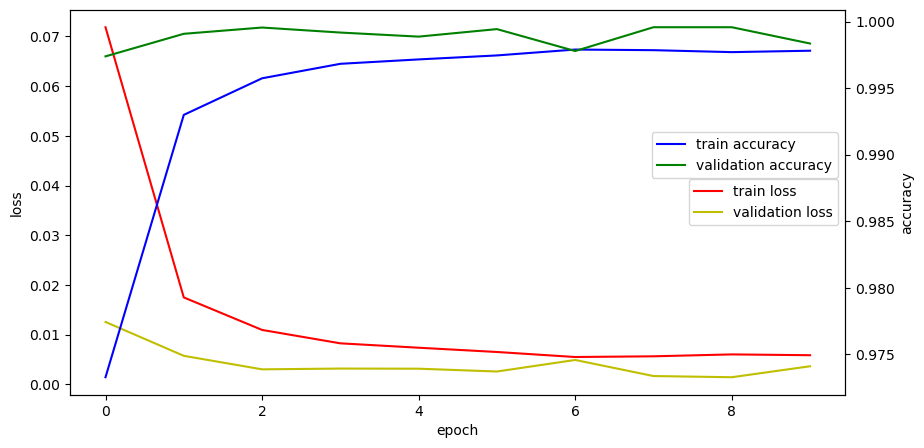

In [31]:
import matplotlib.pyplot as plt

# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(history.history['loss'], 'r', label='train loss')
loss_ax.plot(history.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(history.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [32]:
# 모델 평가
model.evaluate(X_test, y_test)

1328/1328 [==============================] - 1s 1ms/step - loss: 0.0036 - accuracy: 0.9984


[0.003627643221989274, 0.9983521103858948]

In [4]:
from tensorflow.keras.models import load_model
model = load_model('model/model.h5')

In [ ]:
model.predict()

In [143]:
y_hat = model.predict([X_test])

for y, h in zip(y_test, y_hat.reshape(len(y_hat))):
    print("실제값:{}, 예측값:{}".format(round(y,1), round(h,1)))

1328/1328 [==============================] - 1s 988us/step
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:1, 예측값:1.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:1, 예측값:1.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:1, 예측값:1.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:1, 예측값:1.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:1, 예측값:1.0
실제값:0, 예측값:0.0
실제값:0, 예측값:

실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:1, 예측값:1.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:1, 예측값:1.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:1, 예측값:1.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:1, 예측값:0.800000011920929
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:1, 예측값:1.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:1, 예측값:1.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:

실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:1, 예측값:1.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:1, 예측값:1.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:1, 예측값:1.0
실제값:0, 예측값:0.0
실제값:1, 예측값:1.0
실제값:1, 예측값:1.0
실제값:1, 예측값:1.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:1, 예측값:0.8999999761581421
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:1, 예측값:1.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:1, 예측값:1.0
실제값:1, 예측값:1.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값:0.0
실제값:0, 예측값

In [142]:
y_hat.reshape(len(y_hat))

(42478,)

In [42]:
X_test[0]

array([1.        , 0.1       , 0.09733333, 0.61842105, 0.21928481,
       0.70219339, 0.1453027 ])

In [43]:
model.predict(X_test[0].reshape(1, -1))

1/1 [==============================] - 0s 22ms/step


array([[1.6928917e-33]], dtype=float32)

In [123]:
pd.DataFrame(X_test)

,0,1,2,3,4,5,6
0,1.0,0.100000,0.097333,0.618421,0.219285,0.702193,0.145303
1,0.0,0.166667,0.097333,0.723684,0.157321,0.616279,0.166901
2,0.0,0.466667,0.077333,0.540984,0.183525,0.454545,0.109718
3,0.0,0.100000,0.042667,0.800000,0.134550,0.430380,0.155609
4,0.0,0.200000,0.146667,0.539823,0.236822,0.767515,0.126173
...,...,...,...,...,...,...,...
42473,0.5,0.166667,0.177333,0.808824,0.113004,0.700753,0.157177
42474,0.0,0.100000,0.226667,0.774566,0.137409,0.572104,0.152781
42475,0.0,0.166667,0.309333,0.791489,0.277671,0.383929,0.187192
42476,1.0,0.233333,0.340000,0.872093,0.344400,0.631436,0.150313


In [121]:
sampled_data

,user_product_reorder_rate,user_product_reorder_days,user_total_products,user_reorder_rate,user_avg_cart_size,product_reorder_rate,product_avg_add_to_cart,target
2104452,0.000000,3.0,249,0.795181,12.244980,0.833370,8.206471,0
1778621,0.000000,3.0,35,0.542857,3.828571,0.369369,10.798799,0
693261,0.000000,7.0,115,0.782609,8.495652,0.000000,12.750000,0
987498,1.000000,6.5,166,0.765060,9.801205,0.638332,10.665403,0
907009,0.000000,2.0,91,0.659341,10.681319,0.413043,7.630435,0
...,...,...,...,...,...,...,...,...
293962,0.000000,8.0,79,0.493671,6.734177,0.733333,8.785185,0
1989440,0.000000,6.0,158,0.689873,13.012658,0.597222,9.625000,0
23511,0.666667,13.0,119,0.705882,10.075630,0.708300,9.627720,0
257985,0.000000,13.0,58,0.482759,6.362069,0.750078,9.472248,0


In [120]:
final_pro = final_data[final_data['target'] == 0]['product_id']
final_pro.info()

<class 'pandas.core.series.Series'>
Int64Index: 1882903 entries, 0 to 2123872
Series name: product_id
Non-Null Count    Dtype
--------------    -----
1882903 non-null  int64
dtypes: int64(1)
memory usage: 28.7 MB


In [119]:
order_details.groupby('product_id').apply(lambda x : 1 if x==)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2583277,1,18,1,128033,prior,26,1,9,7.0,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2294387,1,10,0,34179,prior,37,2,11,7.0,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
2,1220882,1,2,1,141947,prior,13,2,13,14.0,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
3,1761751,1,4,0,139616,prior,8,2,8,3.0,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
4,1580708,1,1,0,173443,prior,42,2,0,16.0,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3633799,1428413,49321,3,1,189829,prior,9,1,12,6.0,Spicy Kaimal Ketchup,72,13,condiments,pantry
3633800,1332611,49406,9,0,49463,prior,24,2,4,5.0,Giant Roll Bath Tissue Essentials Strong Toile...,100,21,missing,missing
3633801,1606714,49532,6,0,38900,prior,29,5,12,12.0,Pancake & Waffle Mix Gluten Free,17,13,baking ingredients,pantry
3633802,2946207,49565,1,0,3523,prior,20,2,15,30.0,"Batteries, Lithium, AA",87,17,more household,household


In [21]:
import requests

client_id = "T3xJlimKqJrEwhcK6VTd"
client_secret = "uqGAxFqUDv"
headers = {
    "X-Naver-Client-Id": client_id,
    "X-Naver-Client-Secret": client_secret
}

query = "유기농 식품"
url = f"https://openapi.naver.com/v1/search/news.json?query={query}&display=100&sort=date"
response = requests.get(url, headers=headers)
data = response.json()

# 데이터 확인
for item in data['items']:
    print(item['title'], item['link'])

NS홈쇼핑, 한상차림 간편하게 '설 <b>식품</b> 집중편성' https://n.news.naver.com/mnews/article/014/0005296096?sid=101
강진 믿음영농, 건강과 맛을 담은 ‘누룽지칩&amp;버섯스낵’ 출시 https://www.viva100.com/article/20250115501037
[기획] 급식업계, 줄어드는 학생보다 늘어나는 시니어 공략 http://www.m-i.kr/news/articleView.html?idxno=1199452
골든벨통상, <b>유기농</b> NFC 레몬즙 스틱형 출시 https://www.dailysecu.com/news/articleView.html?idxno=163012
[오늘의 제약리뷰] 유유제약‧JW중외제약‧동아제약‧동국제약 http://www.financialreview.co.kr/news/articleView.html?idxno=32631
강진 믿음영농, 건강과 맛 담은 '누룽지칩&amp;버섯스낵' 출시 http://www.welfarenews.net/news/articleView.html?idxno=107269
NS홈쇼핑, 설 연휴 대비 <b>식품</b> 특별 편성 https://www.healthinnews.co.kr/view.php?ud=202501151206073607204ead0791_48
[단독] &quot;맥주처럼 마시자&quot;…이마트, G7 캔와인 '세계 최초' 출시 https://n.news.naver.com/mnews/article/015/0005082521?sid=101
[이BIO] 동국제약·한미사이언스·차병원 외 http://www.newsprime.co.kr/news/article.html?no=671134
산엔청쇼핑몰, 설 명절 맞이 기획전 마련 https://www.newsgn.com/news/articleView.html?idxno=461018
NS홈쇼핑, '긴 연휴' 대비 명절 먹거리 방송 집중 편성 https://www.ziksir.com/new

In [42]:
reordered_products = order_products.groupby('product_id')['reordered'].mean()

In [44]:
products_real = pd.merge(reordered_products, products, on='product_id', how='left')

In [56]:
products_real_real = products_real[products_real['reordered'] > 0.6]

In [57]:
pd.merge(departments, products_real_real, on='department_id', how='left')

,department_id,department,product_id,reordered,product_name,aisle_id
0,1,frozen,130.0,0.620083,Vanilla Milk Chocolate Almond Ice Cream Bars M...,37.0
1,1,frozen,162.0,0.691807,Organic Mini Homestyle Waffles,52.0
2,1,frozen,1398.0,0.708058,Ice Bag,37.0
3,1,frozen,2326.0,0.668617,Organic Blueberry Waffles,52.0
4,1,frozen,2452.0,0.634391,Naturals Chicken Nuggets,129.0
...,...,...,...,...,...,...
1031,20,deli,40396.0,0.660356,Guacamole,67.0
1032,20,deli,41588.0,0.616879,Firm Tofu,14.0
1033,20,deli,42585.0,0.663611,Organic Extra Firm Tofu,14.0
1034,20,deli,45788.0,0.618570,Garlic Lovers Hommus,67.0


In [52]:
departments

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [1]:
import sys
sys.version

'3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]'

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import rc

# 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

불필요 구매 트렌드 분석


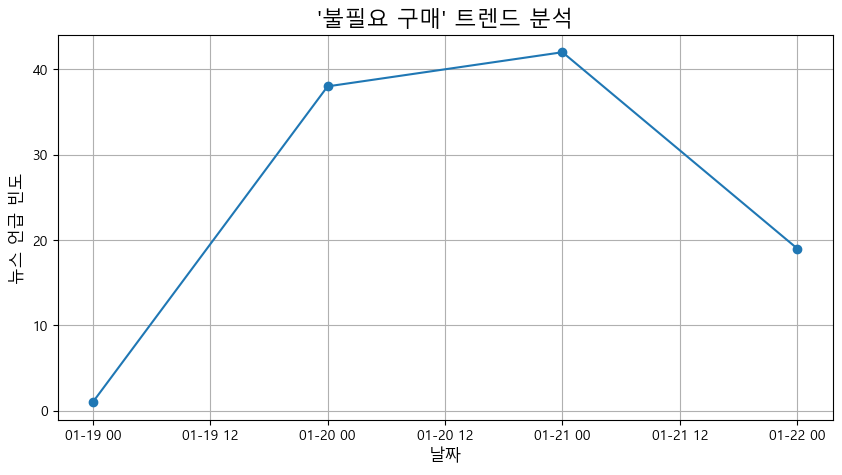

In [28]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import rc

# 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# Naver API 인증 정보
client_id = "T3xJlimKqJrEwhcK6VTd"
client_secret = "uqGAxFqUDv"

# 키워드 검색 함수
def search_keyword(keyword, display=100):
    url = f"https://openapi.naver.com/v1/search/news.json"
    headers = {
        "X-Naver-Client-Id": client_id,
        "X-Naver-Client-Secret": client_secret,
    }
    params = {
        "query": keyword,
        "start": 1,
        "display": display,
        "sort": "date"
    }
    
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error Code: {response.status_code}")
        return None

# 데이터 수집 및 시각화
def analyze_trends(keyword, display=100):
    print(f"{keyword} 트렌드 분석")
    
    # 데이터 수집
    result = search_keyword(keyword, display)
    items = result['items']
    
    # 날짜 추출 및 정리
    dates = [datetime.strptime(item['pubDate'], '%a, %d %b %Y %H:%M:%S +0900').date() for item in items]
    df = pd.DataFrame({"Date": dates})
    df = df['Date'].value_counts().sort_index()
    
    # 트렌드 시각화
    plt.figure(figsize=(10, 5))
    df.plot(kind='line', marker='o')
    plt.title(f"'{keyword}' 트렌드 분석", fontsize=16)
    plt.xlabel("날짜", fontsize=12)
    plt.ylabel("뉴스 언급 빈도", fontsize=12)
    plt.grid()
    plt.show()

# 키워드 분석 실행
analyze_trends("불필요 구매")

In [8]:
items = search_keyword('불필요 구매', "2025-01-01", '2025-01-15')

In [9]:
items

{'lastBuildDate': 'Wed, 22 Jan 2025 14:24:30 +0900',
 'total': 67725,
 'start': 1,
 'display': 100,
 'items': [{'title': '&quot;휴머노이드 로봇시대 이끈다&quot;…산업부, 산업 AI 확산 10대 과제',
   'originallink': 'https://www.newsis.com/view/NISX20250122_0003041824',
   'link': 'https://n.news.naver.com/mnews/article/003/0013030549?sid=101',
   'description': '통해 <b>불필요</b>한 규제 개선에 나설 계획이다. AI산업정책위원회 소속 기술동향·미래산업·표준·정책제언 등... 공급망·<b>구매</b> 효율화, 연구개발 등 12개 핵심과업을 중심으로 국내 수준, 미래발전방향 등을 도출해... ',
   'pubDate': 'Wed, 22 Jan 2025 14:00:00 +0900'},
  {'title': '테이블패커, 시세와 신선도의 통합으로 2025 맞춤형 식자재 쇼핑 플랫폼...',
   'originallink': 'http://www.thepowernews.co.kr/news/articleView.html?idxno=149586',
   'link': 'http://www.thepowernews.co.kr/news/articleView.html?idxno=149586',
   'description': '이 플랫폼은 지난 한 달간의 시세 데이터를 그래프로 제공하여 고객이 시세 변동 상황을 한눈에 파악하고, 최적의 <b>구매</b> 시점을 결정할 수 있게 한다. 이를 통해 고객은 <b>불필요</b>한 비용을 절감하고 신선도 높은 식자재를 보다... ',
   'pubDate': 'Wed, 22 Jan 2025 11:26:00 +0900'},
  {'title': '[2025 소비자가 뽑은 가장 신뢰하는 브랜드대

충동구매 트렌드 분석


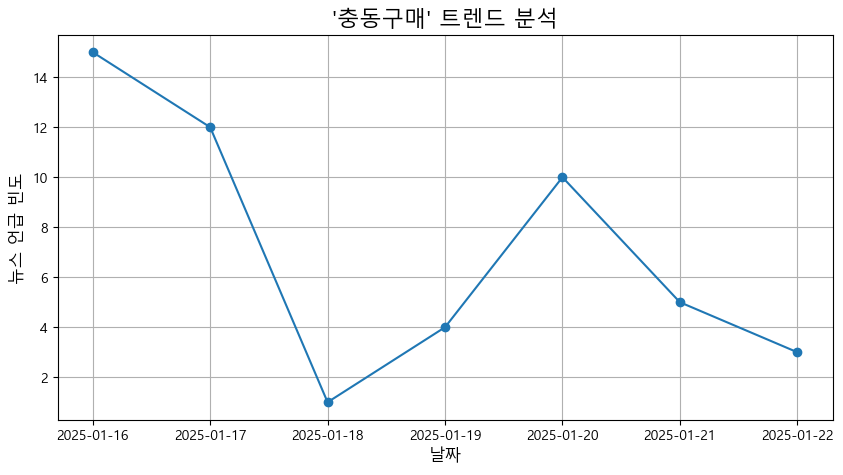

In [26]:
analyze_trends('충동구매', 50)

불필요 구매 워드클라우드 생성 중...


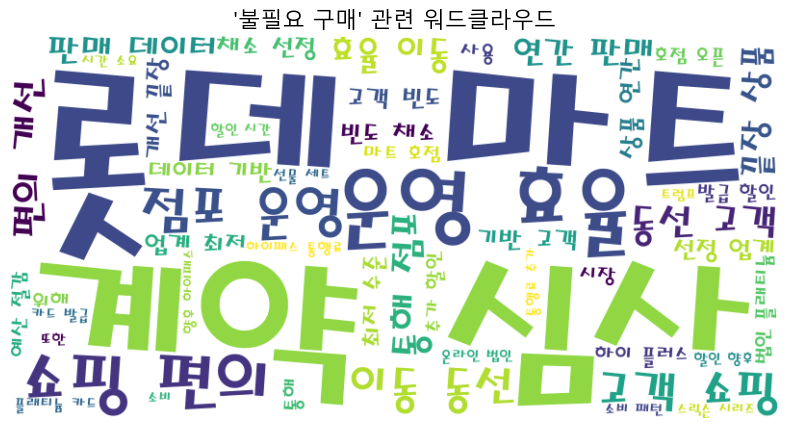

In [45]:
from wordcloud import WordCloud
from konlpy.tag import Okt  # 한글 텍스트 처리를 위한 라이브러리
import matplotlib.pyplot as plt
import re

# 키워드 검색 함수 (위에서 정의된 search_keyword 함수 사용)
# ...

# 워드클라우드 생성 함수
def generate_wordcloud(keyword, max_results=500, display=100):
    print(f"{keyword} 워드클라우드 생성 중...")

    # 데이터 수집
    items = search_keyword(keyword, max_results, display)
    if not items:
        print("데이터 수집 실패")
        return

    # 뉴스 제목과 설명 추출
    texts = " ".join([item['title'] + " " + item['description'] for item in items])

    # 텍스트 전처리
    texts = re.sub(r'<[^>]+>', '', texts)  # HTML 태그 제거
    texts = re.sub(r'[^가-힣\s]', '', texts)  # 한글과 공백만 남기기

    # 품사 태깅
    okt = Okt()
    words = okt.nouns(texts)

    # 불용어 제거
    stopwords = ["구매", "제품", "소비자", "불필요"]  # 프로젝트와 관련 없는 단어 제거
    words = [word for word in words if word not in stopwords and len(word) > 1]

    # 단어 빈도 기반 워드클라우드 생성
    wordcloud = WordCloud(
        font_path='C:/Windows/Fonts/HMKMMAG.TTF',  # 한글 폰트 경로
        background_color="white",
        max_words=50,
        relative_scaling=0.2,
        width=800,
        height=400
    ).generate(" ".join(words))

    # 워드클라우드 시각화
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"'{keyword}' 관련 워드클라우드", fontsize=16)
    plt.show()

# 워드클라우드 생성 실행
generate_wordcloud("불필요 구매", 300, 50)

충동 구매 워드클라우드 생성 중...


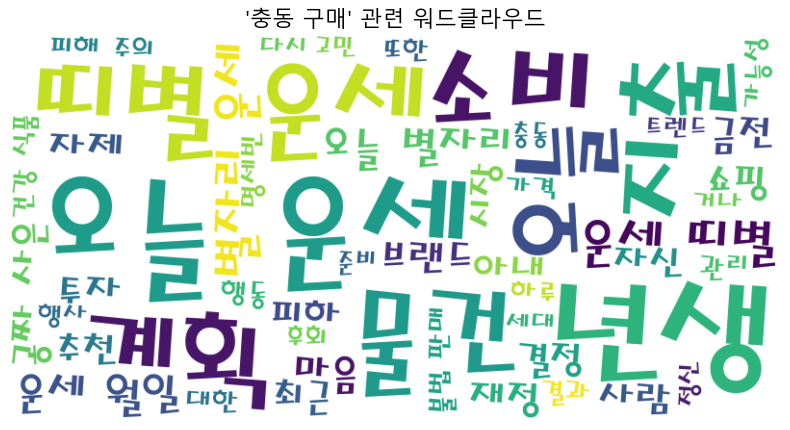

In [46]:
generate_wordcloud("충동 구매", 300, 50)

In [31]:
import requests
import pandas as pd
import time  # API 호출 간격 조절

# 키워드 검색 함수 (페이지네이션 포함)
def search_keyword(keyword, max_results=1000, display=100):
    
    collected_items = []
    start = 1

    while start < max_results:
        # API 요청 URL 및 파라미터
        url = "https://openapi.naver.com/v1/search/news.json"
        headers = {
            "X-Naver-Client-Id": client_id,
            "X-Naver-Client-Secret": client_secret,
        }
        params = {
            "query": keyword,
            "start": start,
            "display": display,
            "sort": "date",
        }
        
        # API 요청
        response = requests.get(url, headers=headers, params=params)
        
        if response.status_code == 200:
            result = response.json()
            items = result.get("items", [])
            
            # 수집된 데이터 추가
            collected_items.extend(items)
            
            # 다음 페이지로 이동
            start += display
            
            # 요청 간격 조절 (1초 딜레이 권장)
            time.sleep(1)
        else:
            print(f"Error Code: {response.status_code}")
            break

    return collected_items

In [34]:
search_keyword('불필요 구매', 100, 10)

[{'title': "예스24, 모바일앱에 'AI 도서 표지 검색 서비스' 오픈",
  'originallink': 'https://www.digitaltoday.co.kr/news/articleView.html?idxno=550760',
  'link': 'https://www.digitaltoday.co.kr/news/articleView.html?idxno=550760',
  'description': "예스24가 책 표지 이미지 촬영만으로 도서명과 <b>구매</b> 페이지를 찾아볼 수 있는 'AI 도서 표지 검색 서비스'를... 예스24 권민석 플랫폼본부 이사는 &quot;검색창을 띄우거나 텍스트를 입력하는 등 검색에 드는 <b>불필요</b>한 시간을... ",
  'pubDate': 'Wed, 22 Jan 2025 14:30:00 +0900'},
 {'title': '&quot;휴머노이드 로봇시대 이끈다&quot;…산업부, 산업 AI 확산 10대 과제',
  'originallink': 'https://www.newsis.com/view/NISX20250122_0003041824',
  'link': 'https://n.news.naver.com/mnews/article/003/0013030549?sid=101',
  'description': '통해 <b>불필요</b>한 규제 개선에 나설 계획이다. AI산업정책위원회 소속 기술동향·미래산업·표준·정책제언 등... 공급망·<b>구매</b> 효율화, 연구개발 등 12개 핵심과업을 중심으로 국내 수준, 미래발전방향 등을 도출해... ',
  'pubDate': 'Wed, 22 Jan 2025 14:00:00 +0900'},
 {'title': '테이블패커, 시세와 신선도의 통합으로 2025 맞춤형 식자재 쇼핑 플랫폼...',
  'originallink': 'http://www.thepowernews.co.kr/news/articleView.html?idxno=149586',
  'link': 'http:

In [39]:
def analyze_trends(keyword, max_results=1000, display=100):
    print(f"{keyword} 트렌드 분석")
    
    # 데이터 수집
    items = search_keyword(keyword, max_results, display)
    
    # 날짜 추출 및 정리
    dates = [datetime.strptime(item['pubDate'], '%a, %d %b %Y %H:%M:%S +0900').date() for item in items]
    df = pd.DataFrame({"Date": dates})
    df = df['Date'].value_counts().sort_index()
    
    # 트렌드 시각화
    plt.figure(figsize=(15, 5))
    df.plot(kind='line', marker='o')
    plt.title(f"'{keyword}' 트렌드 분석", fontsize=16)
    plt.xlabel("날짜", fontsize=12)
    plt.ylabel("뉴스 언급 빈도", fontsize=12)
    plt.grid()
    plt.show()

충동 구매 트렌드 분석


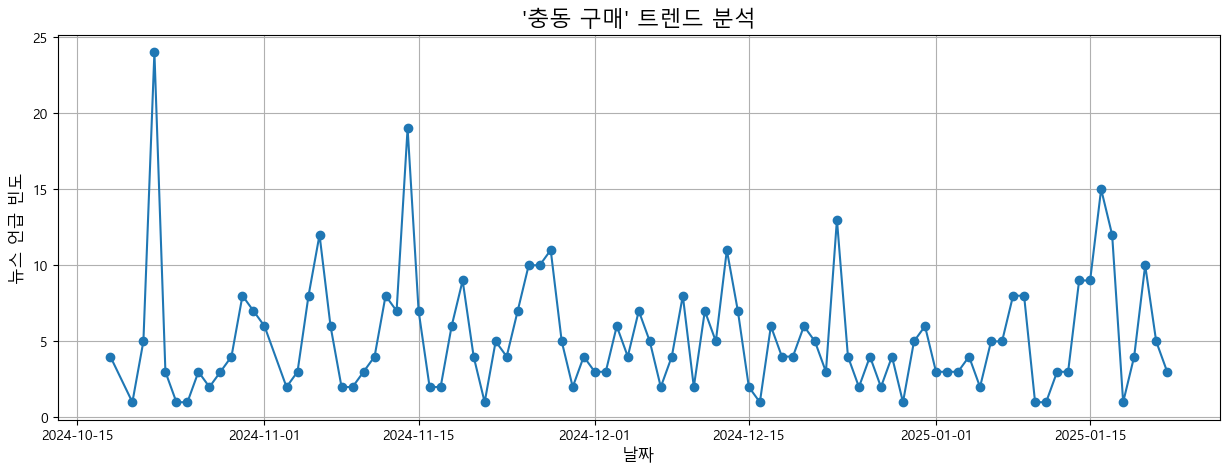

In [40]:
analyze_trends('충동 구매', max_results = 500)

불필요 구매 트렌드 분석


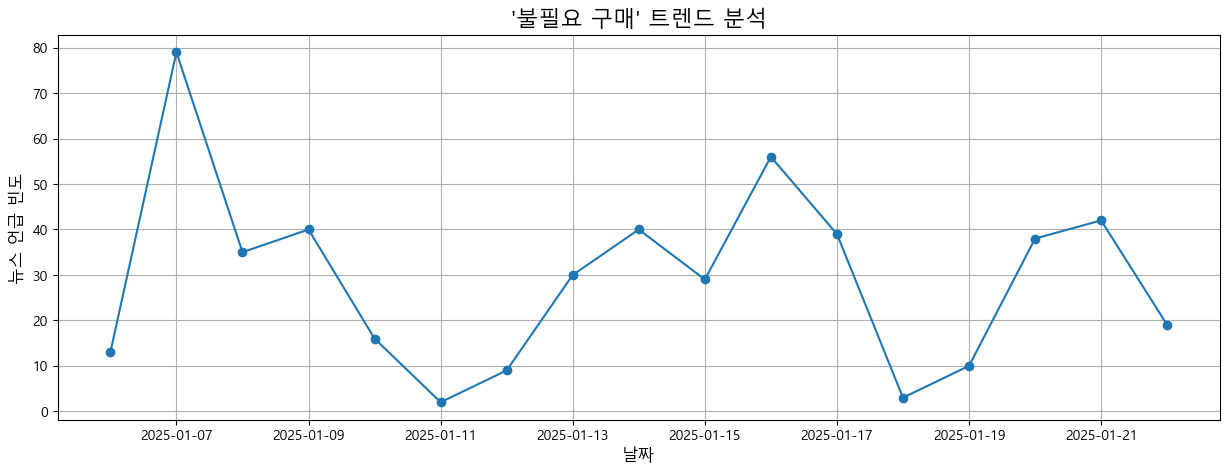

In [41]:
analyze_trends('불필요 구매', max_results = 500)